In [1]:
import urllib

In [2]:
housing_url="https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
download_path="housing.csv"
def fetch_housing_data(housing_url, download_path):
    urllib.request.urlretrieve(housing_url,download_path)
    

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
housing = pd.read_csv("housing.csv")

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We notice missing values in total_bedrooms

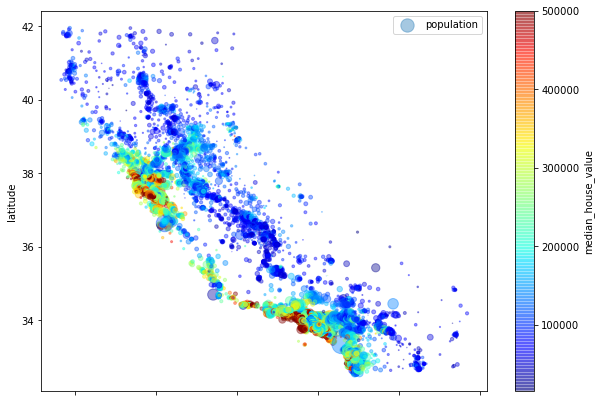

In [5]:
housing.plot(kind='scatter', x='longitude',y='latitude',alpha=0.4, s=housing['population']/100,
             label='population',figsize=(10,7),c='median_house_value',cmap=plt.get_cmap('jet'),
            colorbar=True)
plt.show()

Certain areas close to the ocean show higher prices, however distance to ocean is not a definitive predictor (as shown north of the city). A clustering algorithm should be helpful to identify this hubs.

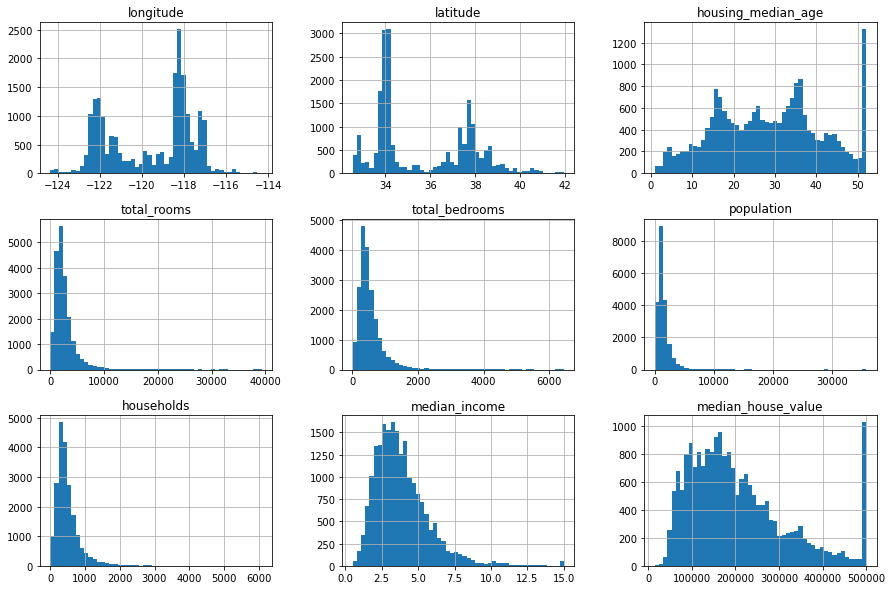

In [6]:
housing.hist(figsize=(15,10),bins=50)
plt.show()

housing_median_age, median_house_value have overcrowded top values

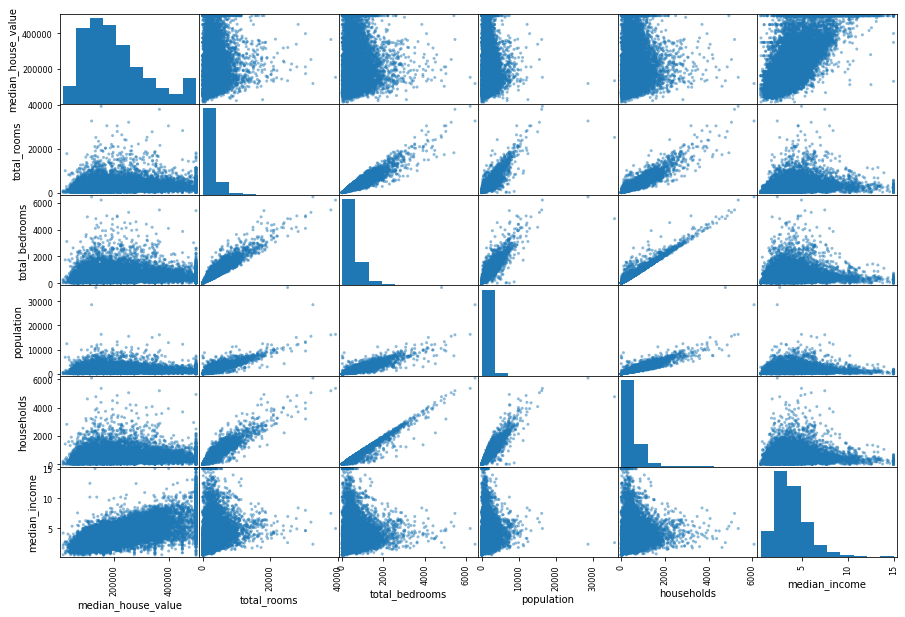

In [7]:
## Let's see correlation among relevant attributes

attributes = ['median_house_value','total_rooms','total_bedrooms','population',
              'households','median_income']

pd.plotting.scatter_matrix(housing[attributes],figsize=(15,10))
plt.show()

Median income seems the most promising attribute to predict house value

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

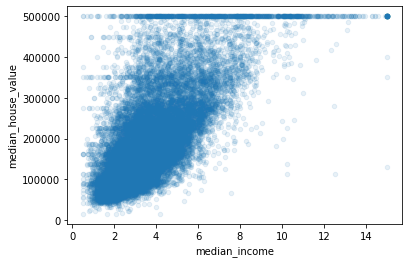

In [8]:
housing.plot(kind="scatter", x='median_income', y='median_house_value',alpha=0.1)

There are a few horizontal lines in certain price points that we could clean up

In [9]:
# We are gonna add a few (possibly) relevant attributes

housing['rooms_hh']=housing['total_rooms']/housing['households']
housing['bed_room']=housing['total_bedrooms']/housing['total_rooms']
housing['pop_hh']=housing['population']/housing['households']

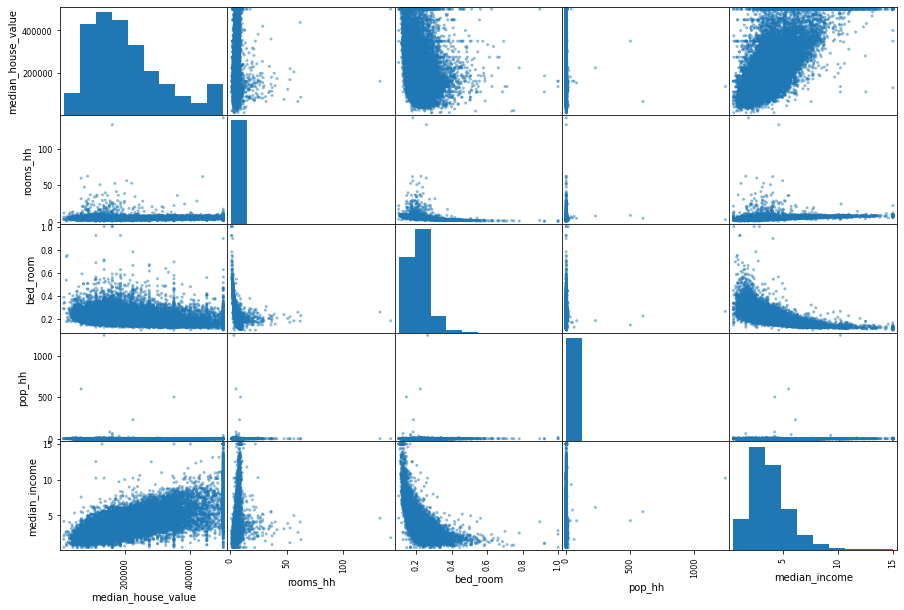

In [10]:
attributes_2 = ['median_house_value','rooms_hh','bed_room','pop_hh','median_income']

pd.plotting.scatter_matrix(housing[attributes_2],figsize=(15,10))
plt.show()

In [11]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_hh              0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
pop_hh               -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bed_room             -0.255880
Name: median_house_value, dtype: float64

# Data Preparation

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

housing = pd.read_csv("housing.csv")
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0,1.5,3.0,4.5,6,np.inf],
                               labels=[1,2,3,4,5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)
    
housing = strat_train_set.drop('median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Now let's create an imputer to deal with missing values using median

In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [16]:
X=imputer.transform(housing_num)

In [17]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

In [18]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[['ocean_proximity']]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Custom Transformer

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipelines

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [21]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat',OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train a Model

## Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [23]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prep = full_pipeline.transform(some_data)

In [24]:
print('Predictions:', lin_reg.predict(some_data_prep))
print('Some Labels:', list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Some Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [25]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

## Desion Tree Regressor

In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is not that the model is perfect. It has just overfit the data badly.

## Evaluation using Cross-Validation

In [30]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg,housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)


In [35]:
def rmse_scores(scores,util=True):
    if util:
        scores=np.sqrt(-scores)
    else:
        scores=np.sqrt(scores)
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

In [36]:
rmse_scores(tree_scores)

Scores: [68414.3680645  68591.05685814 71717.37264417 69586.07285303
 70881.85260014 77304.86255002 70778.13881347 71162.11874956
 74905.18962979 69683.60836597]
Mean: 71302.46411287879
Standard Deviation: 2662.9235080058356


## Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [39]:
forest_scores = cross_val_score(forest_reg, housing_prepared,
                                housing_labels, cv=10, scoring='neg_mean_squared_error')

In [40]:
rmse_scores(forest_scores)

Scores: [49211.51421464 47542.88098613 49780.43707246 52721.50070575
 49744.12248923 53914.05339411 48872.29074791 48154.28246581
 53068.64488994 50117.33706253]
Mean: 50312.70640285185
Standard Deviation: 2064.705858017161


## Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[30,40],'max_features': [8,10]},
    {'bootstrap':[False], 'n_estimators':[10,20],'max_features':[4,6]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 10], 'n_estimators': [30, 40]},
                         {'bootstrap': [False], 'max_features': [4, 6],
                          'n_estimators': [10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 20}

In [44]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=20)

In [45]:
grid_search.cv_results_

{'mean_fit_time': array([1.12219326, 1.48709885, 1.36762166, 1.86756746, 0.35243813,
        0.67352025, 0.47153227, 0.95730186]),
 'std_fit_time': array([0.00088094, 0.00221628, 0.00752989, 0.04854025, 0.01915949,
        0.00611289, 0.00304182, 0.00977417]),
 'mean_score_time': array([0.02902095, 0.03839906, 0.03007142, 0.03930076, 0.01220075,
        0.0236915 , 0.01194692, 0.02589957]),
 'std_score_time': array([7.29777249e-05, 5.08468574e-05, 1.26683259e-03, 1.23715102e-03,
        1.52073222e-04, 6.84055585e-04, 2.86876109e-05, 2.40583255e-03]),
 'param_max_features': masked_array(data=[8, 8, 10, 10, 4, 4, 6, 6],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[30, 40, 30, 40, 10, 20, 10, 20],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_bootstrap': masked_array(data=[-

In [48]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

50580.228086550065 {'max_features': 8, 'n_estimators': 30}
50488.63885508582 {'max_features': 8, 'n_estimators': 40}
50931.31983076431 {'max_features': 10, 'n_estimators': 30}
50641.821588033294 {'max_features': 10, 'n_estimators': 40}
52049.98218561783 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
50774.93805473912 {'bootstrap': False, 'max_features': 4, 'n_estimators': 20}
52010.06275890854 {'bootstrap': False, 'max_features': 6, 'n_estimators': 10}
50129.35427401738 {'bootstrap': False, 'max_features': 6, 'n_estimators': 20}


## Analyze the Best Models and Their Errors

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.68432770e-02, 7.30247641e-02, 4.39717613e-02, 1.76299842e-02,
       1.57930233e-02, 1.77354071e-02, 1.57706444e-02, 3.28310946e-01,
       6.01138212e-02, 1.05453337e-01, 6.92710391e-02, 1.09015281e-02,
       1.56839907e-01, 6.27846652e-05, 2.90103295e-03, 5.37674218e-03])

In [53]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32831094614203227, 'median_income'),
 (0.07684327701364321, 'longitude'),
 (0.0730247641102366, 'latitude'),
 (0.06011382124697679, 'a'),
 (0.04397176130687233, 'housing_median_age'),
 (0.017735407050378, 'population'),
 (0.0176299841902773, 'total_rooms'),
 (0.015793023299737405, 'total_bedrooms'),
 (0.0157706444203104, 'households')]

## Evaluate Your System on the Test Set

In [54]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [55]:
final_rmse

48088.04549206191

## Exercise 1

In [59]:
from sklearn.svm import SVR

svr = SVR()
param_grid=[
    {'kernel':['linear','rbf'], 'C':[1,8],'gamma':[0.5,10]}
]
grid_search = GridSearchCV(svr, param_grid, cv=3,
                           scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [1, 8], 'gamma': [0.5, 10],
                          'kernel': ['linear', 'rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

113570.79729869253 {'C': 1, 'gamma': 0.5, 'kernel': 'linear'}
118865.43525803996 {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
113570.79729869253 {'C': 1, 'gamma': 10, 'kernel': 'linear'}
118934.81727533303 {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
90524.73408351699 {'C': 8, 'gamma': 0.5, 'kernel': 'linear'}
118341.3487484977 {'C': 8, 'gamma': 0.5, 'kernel': 'rbf'}
90524.73408351699 {'C': 8, 'gamma': 10, 'kernel': 'linear'}
118933.47473237262 {'C': 8, 'gamma': 10, 'kernel': 'rbf'}


In [61]:
grid_search.best_estimator_

SVR(C=8, gamma=0.5, kernel='linear')

## Exercise 2

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(10000, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=3, cv=3, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42,n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   28.7s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   32.3s finished


RandomizedSearchCV(cv=3, estimator=SVR(), n_iter=3, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72fdd99490>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72fdd97670>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [64]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

59882.69682506849

In [65]:
rnd_search.best_params_

{'C': 103371.63339642635, 'gamma': 0.9084469696321253, 'kernel': 'rbf'}